This script will attempt to process and plot echosounder and amplitude Data as a means of understanding sediment characteristics.

In [1]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.io import loadmat

In [2]:
deployment_num = 1
sensor_id = "E1_103071"
#directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [10]:
# Create dictionary for each sensor
dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/Processed/",f"{sensor_id}",'Group36')  # path to the directory containing the h5 files
files = os.listdir(dirpath) # list of files for the sensor
Data = {}
for file in files:
    file_path = os.path.join(dirpath, file)  # file path
    df = pd.read_hdf(file_path)  # read the file into a Pandas Dataframe
    file_name = file.split('.')[0]  # file name 
    print(file_name)
    Data[file_name] = df  # store Dataframe
globals()[f"Data_{sensor_id}"] = Data

AbsVel
Time
EastVel
NorthVel
VertVel
ErrVel
Heading
Roll
Pitch
Pressure
VelBeamCorr1
VelBeamCorr2
VelBeamCorr3
VelBeamCorr4
CellDepth
Echo1
Echo2
CellDepth_echo
AmpBeam1
AmpBeam2
AmpBeam3
AmpBeam4
VbAmplitude


In [4]:
filepath = "Z:\deployment_1\Raw\E1RBR\SBE_00003570_DEP4_FPSE1_L0.mat"
stuff = loadmat(
    filepath
)  # Load mat oragnizes the 4 different data structures of the .mat file (Units, Config, Data, Description) as a
# dictionary with four nested numpy arrays with dtypes as data field titles
sbe = {}
for names in stuff.keys() :
    sbe[names] = stuff[names]  # Convert the numpy arrays to a dictionary with the data field titles as keys
    print(f"{names}")  # Print the data field titles
del stuff

__header__
__version__
__globals__
SN
time
conductivity
temperature
pressure
salinity
units
notes


In [5]:
# Attempts at sediment attentuation of the amplitude data, at the start are the required parameters for calculation
S = sbe["salinity"]  # Salinity in ppt
T = sbe["temperature"]  # Temperature in degrees Celsius
P = sbe["pressure"]
ph = 8.1  # pH
freq = 1000  # Frequency in kHz
transmit_power = 0  # Units?
gain_correciton = 0  # Gain correction in dB for E1
transmit_length = 0.330  # ms
beam_angle = .015  # For E1
g = 9.81  # m/s^2
y = 2.226 * 10 ** (-6)  # ms^-2 dBar^-1

copy = Data["Echo1"].copy()  # Copy the Echo1 data to avoid modifying the original
# Broadcast depth (305x1) to (12850x305)
ranges = Data["CellDepth_echo"].values.flatten()  # shape: (305,)
range_matrix = np.tile(ranges, (Data["Echo1"].shape[0], 1))  # shape: (12850, 305)

depths_matrix = Data['Pressure'].values - ranges[np.newaxis, :]  # shape: (12850, 305)

depths_matrix = depths_matrix >= 0 


T0 = float(np.nanmean(T))
S0 = float(np.nanmean(S))


soundspeed = 1448.96 + 4.591*T0 -5.304e-2*T0**2 + 2.374e-4*T0**3 +1.34*(S0-35) # Approximated mackenzie equation for sound speed in water

# Calculate attenuation coefficients
A_1 = (8.66*10**(.78*ph-5))/soundspeed
A_2 = (21.44*S0*(1+.025*T0))/soundspeed
f_1 = 2.8*np.sqrt(S0/35)*10**(4-1245/(T0+273))
f_2 = (8.17*10**(8-(1990/(T0+273))))/(1+.0018*(S0-35))

P_2 = 1 - 1.37e-4*depths_matrix + 6.2e-9*depths_matrix**2
P_3 = 1 - 3.83e-5*depths_matrix + 4.9e-10*depths_matrix**2

if T0 <= 20:
    A_3 = 4.937e-4 -2.59e-5*T0 + 3.2e-7*T0**2 -1.5e-8*T0**3
else:
    A_3 = 3.964e-4 -1.146e-5*T0 +1.45e-7*T0**2 -6.5e-10*T0**3

a_w = (freq**2)*(((A_1*f_1)/(f_1**2+freq**2))+((A_2*P_2*f_2)/(f_2**2+freq**2))+A_3*P_3) # Calculate abosrbtion coefficient shape: (305,)
a_w = a_w/1000 # Convert from dB/km to dB/m

# transmit_length likely in ms → convert to sec:
transmit_length_sec = transmit_length / 1000

# define Csv:
Csv = 0 # or compute properly

Sv = copy*.01 + 20*np.log10(depths_matrix) + 2*a_w*depths_matrix \
           + transmit_power - 10*np.log10((soundspeed*transmit_length_sec)/2) \
           - beam_angle + Csv

Sv = pd.DataFrame(Sv, index=copy.index, columns=copy.columns)



C:\Users\lwlav\AppData\Local\Temp\ipykernel_7632\1174837540.py:53: RuntimeWarning: divide by zero encountered in log10
  Sv = copy*.01 + 20*np.log10(depths_matrix) + 2*a_w*depths_matrix \


***This section will calculate integrated bin values and bin averages***

30 30
(124800, 30)


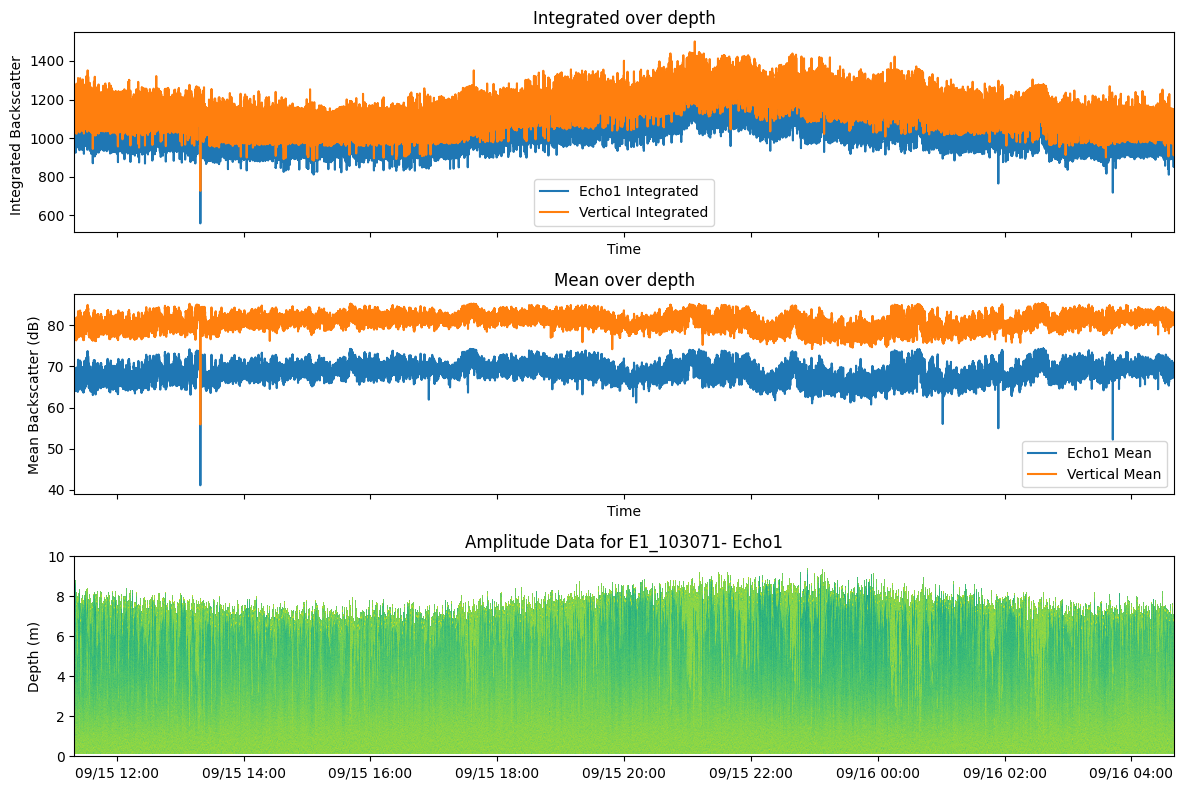

In [ ]:
# Integrated and avg backscatter over depth bins (you have to avg the echosounder to same bin size as vertbeam first)
refact = 10 #The echosounder bin size is 10 times smaller than the vertbeam bin size

row, col = Data['Echo1'].shape
newbin = col//refact

print(newbin,Data['VbAmplitude'].shape[1])

trim_echo1 = Data['Echo1'].iloc[:,:newbin*refact].to_numpy() #This is fine since the last bins are nans over the water surface anyways
trim_echo2 = Data['Echo2'].iloc[:,:newbin*refact].to_numpy()

echo1_rebin = trim_echo1.reshape(row,newbin,refact).mean(axis =2)
echo2_rebin = trim_echo2.reshape(row,newbin,refact).mean(axis =2)

print(echo1_rebin.shape)

echo1_integrated = np.nansum(echo1_rebin,axis = 1)  # shape (N_samples,)
echo1_avg = Data['Echo1'].mean(axis=1)

echo2_integrated = np.nansum(echo2_rebin,axis = 1)
echo2_avg = Data['Echo2'].mean(axis=1)

vertical_integrated = Data['VbAmplitude'].sum(axis=1)
vertical_avg = Data['VbAmplitude'].mean(axis=1)

Sv_integrated = Sv.sum(axis=1)
Sv_avg = Sv.mean(axis=1)

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(Data['Time'],echo1_integrated, label='Echo1 Integrated')
# axs[0].plot(Data['Time'],echo2_integrated, label='Echo2 Integrated')
axs[0].plot(Data['Time'],vertical_integrated, label='Vertical Integrated')
axs[0].set_title('Integrated over depth')
axs[0].set_ylabel('Integrated Backscatter ')
axs[0].set_xlabel('Time')
axs[0].legend()

axs[1].plot(Data['Time'],echo1_avg, label='Echo1 Mean')
# axs[1].plot(Data['Time'],echo2_avg, label='Echo2 Mean')
axs[1].plot(Data['Time'],vertical_avg, label='Vertical Mean')
axs[1].set_title('Mean over depth')
axs[1].set_ylabel('Mean Backscatter (dB)')
axs[1].set_xlabel('Time')
axs[1].legend()

axs[2].pcolormesh(
    Data["Time"][0],
    Data["CellDepth_echo"],
    Data['Echo1'].T,
    shading="auto",
    cmap="viridis", vmin = 0, vmax = 90
)
axs[2].set_title(f"Amplitude Data for {sensor_id}- Echo1")
axs[2].set_ylabel('Depth (m)')
axs[2].set_ylim(0,10)
for ax in axs:
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.tight_layout()
plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_avgvsintegoverdepth_.png")

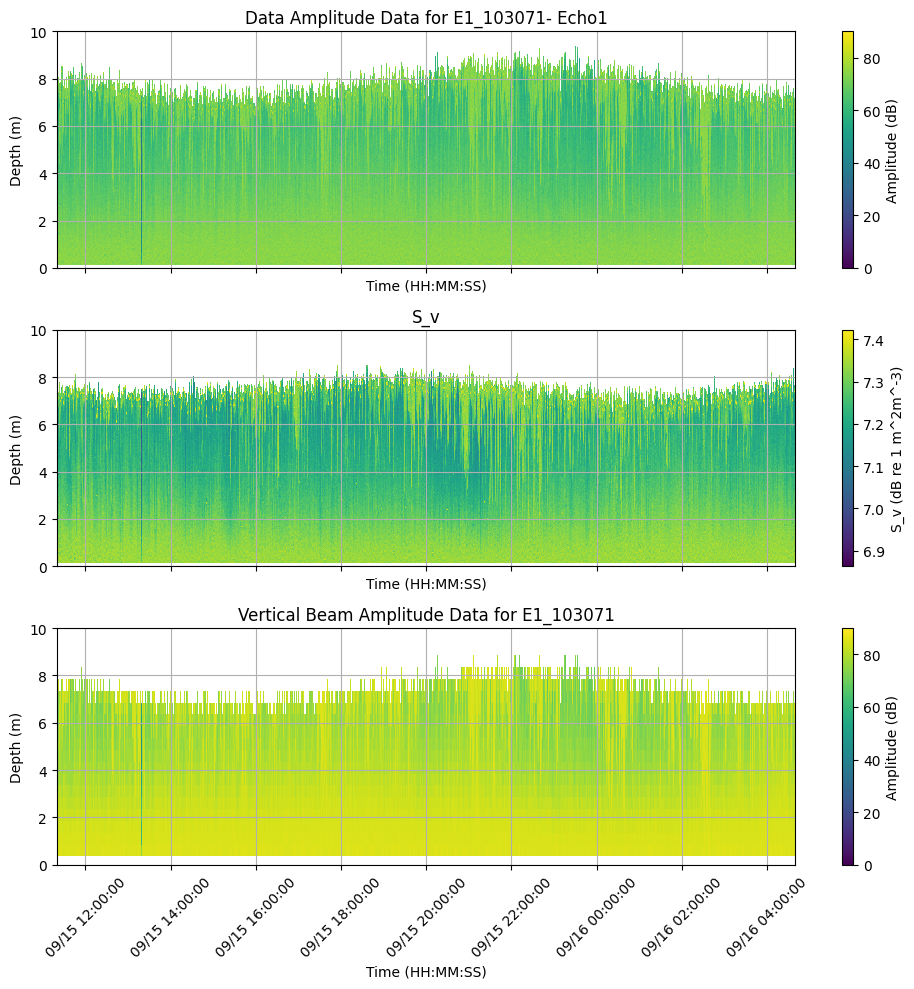

In [ ]:
# Plot the Data amplitude Data for Echo1 and Echo2 and the Vertical Beam using meshgrids
#Echo1 and Echo2 have shapes [Sample,Cells] and Vertical Beam has shape [Sample,Cells] where the Echo cell depth maps the depths of each cell for the echoes, whilw the Vertical Beam uses normal cell depth
fig, (axs1,axs2,axs3)  = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

fig.colorbar(axs1.pcolormesh(
    Data["Time"][0],
    Data["CellDepth_echo"],
    Data['Echo1'].T,
    shading="auto",
    cmap="viridis", vmin = 0, vmax = 90
),ax=axs1, label='Amplitude (dB)')
axs1.set_title(f"Data Amplitude Data for {sensor_id}- Echo1")
fig.colorbar(axs2.pcolormesh(
    Data["Time"][0],
    Data["CellDepth_echo"],
    Sv.T,
    shading="auto",
    cmap="viridis",
),ax=axs2, label='S_v (dB re 1 m^2m^-3)')
axs2.set_title(f"S_v")
fig.colorbar(axs3.pcolormesh(
    Data["Time"][0],
    Data["CellDepth"],
    Data['VbAmplitude'].T,
    shading="auto",
    cmap="viridis",
    vmax=(90),vmin = 0,
),ax=axs3, label='Amplitude (dB)')
axs3.set_title(f"Vertical Beam Amplitude Data for {sensor_id}")


for axs in [axs1,axs2,axs3]:
        axs.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
        axs.set_xlabel("Time (HH:MM:SS)")
        axs.set_ylabel("Depth (m)")
        axs.grid(True)
        axs.set_ylim(0,10) 
        axs.set_xlim(Data["Time"][0].iloc[0], Data["Time"][0].iloc[-1])

        for label in axs.get_xticklabels():
            label.set_rotation(45)
plt.tight_layout()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_Sv_comp.png")

***This section will perform some analyses on Vertical Beam and Echosounder***

22.139599343977842 0.8551500736728799 0.9834277310477979


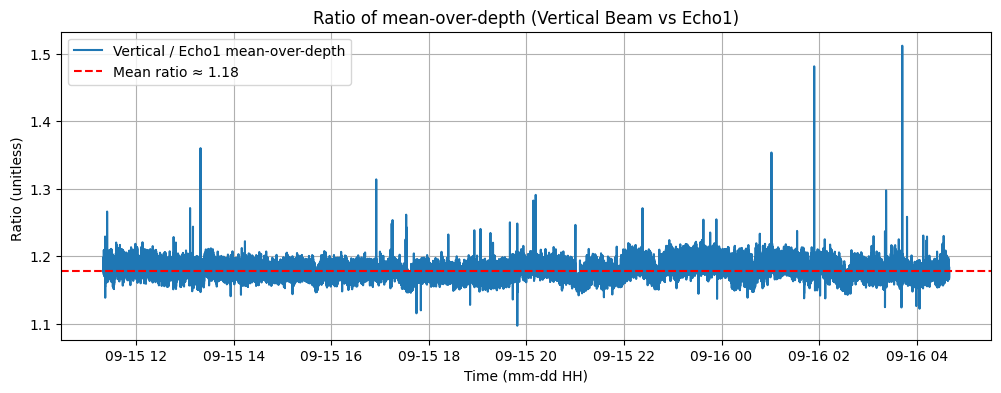

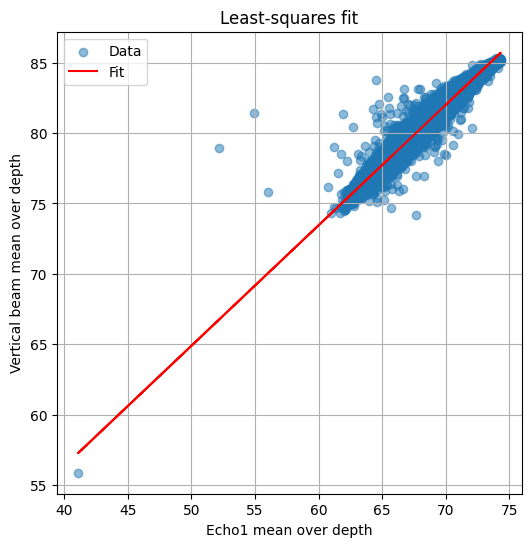

In [24]:
from scipy.stats import linregress

ratio = vertical_avg/echo1_avg
m,b,r2,pval,stderr = linregress(echo1_avg,vertical_avg)

plt.figure(figsize=(12,4))
plt.plot(Data['Time'],ratio, label='Vertical / Echo1 mean-over-depth')
plt.axhline(ratio.mean(), color='red', linestyle='--', label=f'Mean ratio ≈ {ratio.mean():.2f}')
plt.xlabel('Time (mm-dd HH)')
plt.ylabel('Ratio (unitless) ')
plt.title('Ratio of mean-over-depth (Vertical Beam vs Echo1)')
plt.legend()
plt.grid()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_meanratios.png")


plt.figure(figsize=(6,6))
plt.scatter(echo1_avg, vertical_avg, alpha=0.5, label='Data')
plt.plot(echo1_avg, m*echo1_avg + b, color='red', label='Fit')
plt.xlabel('Echo1 mean over depth')
plt.ylabel('Vertical beam mean over depth')
plt.title('Least-squares fit')
plt.legend()
plt.grid()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_linregmeans.png")

print(b,m,r2)